In [1]:
import sqlite3
import numpy as np
import pandas as pd
import seaborn as sns
import fakeInjectionPipeline as fip
import glob
import lsst.afw.image as afwImage
from lsst.afw.table import BaseCatalog

import matplotlib.pyplot as plt
import data_process_utils as dpu
import os

In [2]:
!pwd

/global/cscratch1/sd/shl159/projects/fake_injection_v23/dia_improvement/devel


In [3]:
patch_list = ['00']
host_mag_list = ['20_21']
fake_mag_list = [20, 21, 22, 23, 24]
injection_db_path = ('./data/table/gal_4639/injection_coord.sqlite')
calexp_info_dict, injection_coord_dict = fip.get_calexp_injection_dict(
    patch_list, host_mag_list, dbpath=injection_db_path
)
fake_dir = ('./data/patch_0to6/injection')
injector = fip.fakeInjectionPipeline(
    fake_dir = fake_dir, patch_list = patch_list,
    host_mag_list=host_mag_list, fake_mag_list=fake_mag_list,
    calexp_info_dict=calexp_info_dict, injection_coord_dict=injection_coord_dict
)


In [4]:
cf_type = 'default_v23'

config = f'./config/diffimConfig_al_{cf_type}.py'
file_path = f'./al_{cf_type}.sh'
diff_dir =  f'./data/patch_0to6/diff/al_{cf_type}'
# injector.get_subtraction_script(diff_dir , config=config, file_path=file_path, use_slurm=False)

In [5]:
"""
cf_type = 'convSci_v23'

config = f'./config/diffimConfig_al_{cf_type}.py'
file_path = f'./al_{cf_type}.sh'
diff_dir =  f'./data/patch_0to6/diff/al_{cf_type}'
injector.get_subtraction_script(diff_dir , config=config, file_path=file_path, use_slurm=False)
""";

In [6]:
def get_detection(diff_dir, fake_mag_list = [20, 21, 22, 23, 24]):
    diff_path_pattern = diff_dir +  f'/*/diff_20/*/*/*/*diffexp*.fits'
    diffexp_path_list = glob.glob(diff_path_pattern)
    detection_df = pd.DataFrame()
    for idx, diffexp_path_tmpt in enumerate(diffexp_path_list):

        data_coord = diffexp_path_tmpt.split('/')[5].split('_')
        visit, det, filt = int(data_coord[3]), int(data_coord[4]), str(data_coord[5])
        injected_coord = injection_coord_dict[f'00_20_21_{visit}_{det}_{filt}']
        for fake_id, fake_mag in enumerate(fake_mag_list):

            calexp_tmpt = (f'./data/patch_0to6/injection/00_20_21_{visit}_{det}_{filt}'
                           f'/fake_{fake_mag}/calexp/*/*/*.fits')
            calexp_path = glob.glob(calexp_tmpt)[0]
            diffexp_path = diffexp_path_tmpt.replace('diff_20', f'diff_{fake_mag}')
            diaSrc_path =  diffexp_path.replace('diffexp', 'diaSrc')

            calexp = afwImage.ExposureF(calexp_path)
            photo_calib = calexp.getPhotoCalib()
            diffexp = afwImage.ExposureF(diffexp_path)
            diaSrc = BaseCatalog.readFits(diaSrc_path)
            diaSrc_df = diaSrc.asAstropy().to_pandas()

            detected_coord = diaSrc_df.loc[:, ['base_NaiveCentroid_x', 'base_NaiveCentroid_y']].to_numpy()
            matched_status, matched_id = dpu.two_direction_match(injected_coord, detected_coord, radius=4)
            fakeSrc_df = diaSrc_df.loc[matched_id].reset_index(drop=True)
            fakeSrc_df['matched_status'] = matched_status

            injected_mag_col = np.repeat(fake_mag, len(fakeSrc_df))
            injected_instflux = photo_calib.magnitudeToInstFlux(fake_mag)

            injected_instflux_col = np.repeat(injected_instflux, len(fakeSrc_df))
            visit_col = np.repeat(visit, len(fakeSrc_df))
            det_col = np.repeat(det, len(fakeSrc_df))
            filt_col = np.repeat(filt, len(fakeSrc_df))
            calexp_path_col = np.repeat(calexp_path, len(fakeSrc_df))
            diffexp_path_col = np.repeat(diffexp_path, len(fakeSrc_df))
            diaSrc_path_col = np.repeat(diaSrc_path, len(fakeSrc_df))
            diffexp_info_df = pd.DataFrame(data = {'injected_mag': injected_mag_col, 'injected_instflux': injected_instflux_col,
                                                   'visit': visit_col, 'detector': det_col, 'filter': filt_col,
                                                   'calexp_path': calexp_path_col,
                                                   'diffexp_path': diffexp_path_col, 'diaSrc_path': diaSrc_path_col})
            joint_info_df = pd.concat([fakeSrc_df, diffexp_info_df], axis=1)
            detection_df = pd.concat([detection_df, joint_info_df], axis=0, ignore_index=True)
    return detection_df
        

In [7]:
"""
cf_type = 'default_v23'
diff_dir =  f'./data/patch_0to6/diff/al_{cf_type}'
detv23 = get_detection(diff_dir)
detv23.to_csv('detv23.csv', index=False)

cf_type = 'convSci_v23'
diff_dir =  f'./data/patch_0to6/diff/al_{cf_type}'
detv23_convSci = get_detection(diff_dir)
detv23_convSci.to_csv('detv23_convSci.csv', index=False)
""";

In [8]:
detv23 = pd.read_csv('./detv23.csv')
detv23_convSci = pd.read_csv('./detv23_convSci.csv')

conn = sqlite3.connect('/global/cscratch1/sd/shl159/projects/fake_injection_summer_2022/dia_improvement/devel'
                       '/data/patch_0to6/diff/al_default/detection/detection.sqlite')
query = "SELECT * FROM fake_src WHERE host_mag='20_21' AND patch='00'"
detv20 = pd.read_sql_query(query, conn)


In [9]:
def cal_eff(df, mag_name, fake_mag_list = [20, 21, 22, 23, 24]):
    eff_list = []
    for fake_mag in fake_mag_list:
        fakes = df.loc[df[f'{mag_name}'].astype(int)==fake_mag]
        fakes_det = fakes.loc[fakes['matched_status'].astype(bool)]
        eff = len(fakes_det) / len(fakes)
        eff_list.append(eff)
    return eff_list
    

In [10]:
# calculate effciency
eff_v20 = cal_eff(detv20, 'fake_mag')
eff_v23 = cal_eff(detv23, 'injected_mag')
eff_v23_convSci = cal_eff(detv23_convSci, 'injected_mag')

In [11]:
# calculate residual

det20_v23 = detv23.loc[detv23['injected_mag']==20].reset_index()
det20_v23_convSci = detv23_convSci.loc[detv23_convSci['injected_mag']==20].reset_index()
det20_v20 = detv20.loc[np.logical_and(detv20['matched_status'].astype(bool), detv20['fake_mag'].astype(int)==20)].reset_index()

res_v23 = (det20_v23['base_PsfFlux_instFlux'] - det20_v23['injected_instflux']) /  det20_v23['injected_instflux']
res_v23_convSci = (det20_v23_convSci['base_PsfFlux_instFlux'] - det20_v23_convSci['injected_instflux']) /  det20_v23_convSci['injected_instflux']
res_v20 = (det20_v20['base_PsfFlux_instFlux'] - det20_v20['injected_instFlux']) / det20_v20['injected_instFlux']

In [12]:
len(res_v20), len(res_v23), len(res_v23_convSci)

(169, 169, 169)

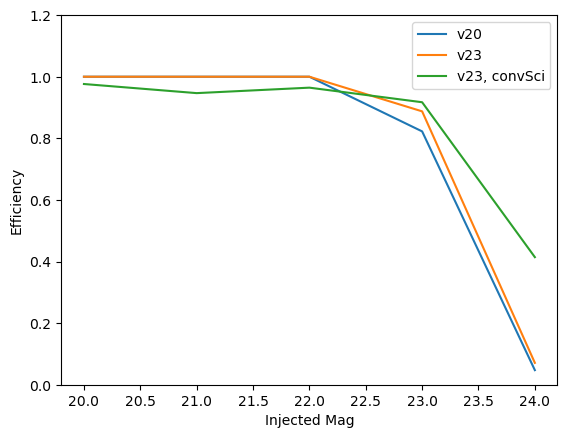

In [13]:
plt.plot(fake_mag_list, eff_v20, label='v20')
plt.plot(fake_mag_list, eff_v23, label='v23')
plt.plot(fake_mag_list, eff_v23_convSci, label='v23, convSci')
plt.ylim(0, 1.2)
plt.ylabel('Efficiency')
plt.xlabel('Injected Mag')
plt.legend()

Text(0.5, 0.98, 'Flux Residual')

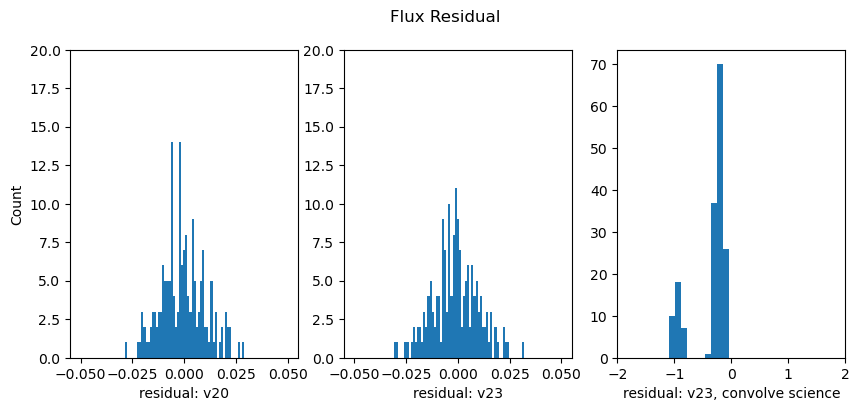

In [15]:
bins = np.linspace(-0.05, 0.05, 100)
ylim = (0, 20)
fig, ax = plt.subplots(1, 3, figsize=(10,4))
ax[0].hist(res_v20, bins=bins)
ax[0].set_xlabel('residual: v20')
ax[0].set_ylabel('Count')
ax[0].set_ylim(ylim)
ax[1].hist(res_v23, bins=bins)
ax[1].set_xlabel('residual: v23')
ax[1].set_ylim(ylim)
ax[2].hist(res_v23_convSci)
ax[2].set_xlabel('residual: v23, convolve science')
ax[2].set_xlim((-2,2))
plt.suptitle('Flux Residual')

In [3]:
# flux_dir = f'./data/patch_0to6/diff/al_{cf_type}/detection'
# injector.get_detection(diff_dir=diff_dir, flux_dir=flux_dir, db_name=f'detection.sqlite')

In [ ]:
conn = sqlite3.connect(f'./data/patch_0to6/diff/al_{config}/detection/detection.sqlite')
query = 'SELECT * FROM fake_src'
fake_src_df = pd.read_sql_query(query, conn)

In [ ]:


patch_list = ['00', '11', '22', '33', '44', '55', '66']
host_mag_list = ['20_21', '21_22', '22_23', '23_24', '24_25']
fake_mag_list = [20, 21, 22, 23, 24]
injection_db_path = './data/table/gal_4639/injection_coord.sqlite'

calexp_info_dict, injection_coord_dict = fip.get_calexp_injection_dict(
    patch_list, host_mag_list, dbpath=injection_db_path
)

fake_dir = f'./data/patch_0to6/injection'

injector = fip.fakeInjectionPipeline(
    fake_dir = fake_dir, patch_list = patch_list,
    host_mag_list=host_mag_list, fake_mag_list=fake_mag_list,
    calexp_info_dict=calexp_info_dict, injection_coord_dict=injection_coord_dict
)

cf_type = 'default'
diff_dir =  f'./data/patch_0to6/diff/al_{cf_type}'
# flux_dir = f'./data/patch_0to6/diff/al_{cf_type}/detection'

# injector.get_detection(diff_dir=diff_dir, flux_dir=flux_dir, db_name=f'detection.sqlite')

flux_db_path = f'./data/patch_0to6/diff/al_{cf_type}/detection/detection.sqlite'
coord_dir = f'./data/patch_0to6/diff/al_{cf_type}/coord'
injector.get_detection_coord(flux_db_path, coord_dir)

forced_dir = f'./data/patch_0to6/diff/al_{cf_type}/forced'
forced_config = './config/forcedConfig.py'
forced_path = f'./forced_al_{cf_type}.sh'
injector.get_forced_phot_script(diff_dir, coord_dir, forced_dir, forced_config, file_path=forced_path)